In [21]:
!python -m pip install einops

In [28]:
!python -m pip show einops

Name: einops
Version: 0.8.1
Summary: A new flavour of deep learning operations
Home-page: https://github.com/arogozhnikov/einops
Author: Alex Rogozhnikov
Author-email: 
License: MIT
Location: /home/evanokeeffe/.cache/pypoetry/virtualenvs/affine-steerers-y6XhOGRI-py3.10/lib/python3.10/site-packages
Requires: 
Required-by: affine-steerers


In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import torch
    import numpy as np
    from PIL import Image
    import cv2
    import matplotlib.pyplot as plt
    import math

In [2]:
# Helper function for drawing matches
def draw_img_match(img1, img2, mkpts1, mkpts2, reverse_pair=True):
    if isinstance(img1, torch.Tensor):
        img1 = im_tensor_to_np(img1)
    if isinstance(img2, torch.Tensor):
        img2 = im_tensor_to_np(img2)
    if isinstance(mkpts1, torch.Tensor):
        mkpts1 = mkpts1.detach().cpu().numpy()
    if isinstance(mkpts2, torch.Tensor):
        mkpts2 = mkpts2.detach().cpu().numpy()

    if isinstance(img1, np.ndarray):
        img1 = np.uint8(255 * img1)
    else:
        img1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
    if isinstance(img2, np.ndarray):
        img2 = np.uint8(255 * img2)
    else:
        img2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)

    if reverse_pair:
        img1, img2, = img2, img1
        mkpts1, mkpts2 = mkpts2, mkpts1

    img = cv2.drawMatches(
        img1=img1,
        keypoints1=[cv2.KeyPoint(x=x, y=y, size=2) for x, y in mkpts1],
        img2=img2,
        keypoints2=[cv2.KeyPoint(x=x, y=y, size=2) for x, y in mkpts2],
        matches1to2=[cv2.DMatch(_trainIdx=i, _queryIdx=i, _distance=-1.) for i in range(len(mkpts1))],
        matchesThickness=2,
        outImg=None,
    )
    plt.imshow(img)

def im_tensor_to_np(x):
    return x[0].permute(1, 2, 0).detach().cpu().numpy()

In [3]:
im_A_path = "/media/evanokeeffe/Processing/4thAve/regular/images/DJI_0003.JPG"
im_B_path = "/media/evanokeeffe/Processing/4thAve/regular/images/DJI_0004.JPG"
im_A = Image.open(im_A_path)
im_B = Image.open(im_B_path)
w_A, h_A = im_A.size
w_B, h_B = im_B.size

In [5]:
from affine_steerers.utils import build_affine, load_default_steerer
from affine_steerers.matchers.dual_softmax_matcher import DualSoftMaxMatcher, MaxSimilarityMatcher
from affine_steerers import dedode_detector_L, dedode_descriptor_B, dedode_descriptor_G

model_name = "aff_equi_G"  # ordinary training
# model_name = "aff_steer_G"  # pretraining + prototype training

detector = dedode_detector_L(
    weights=torch.load("models/dedode_detector_C4.pth")  # Get these weights from https://github.com/georg-bn/rotation-steerers/releases/tag/release-2
)
descriptor_path = f"models/descriptor_{model_name}.pth"  # Get these weights from the releases of this repo
steerer_path = f"models/steerer_{model_name}.pth"
if "G" in descriptor_path:
    descriptor = dedode_descriptor_G(
        weights=torch.load(descriptor_path)
    )
else:
    descriptor = dedode_descriptor_B(
        weights=torch.load(descriptor_path)
    )
steerer = load_default_steerer(
    steerer_path,
).cuda().eval()

steerer.use_prototype_affines = True
# don't use below for AffSteer
steerer.prototype_affines = torch.stack(
    [
        build_affine(
            angle_1=0.,
            dilation_1=1.,
            dilation_2=1.,
            angle_2=r * 2 * math.pi / 8
        )
        for r in range(8)
    ],  # + ... more affines
    dim=0,
).cuda()

matcher = DualSoftMaxMatcher(
    #steerer=steerer,
    normalize=False,
    inv_temp=5,
    threshold=0.01,
)

In [6]:
# Detection of keypoints
detections_A = detector.detect_from_path(im_A_path, num_keypoints = 10_000)
keypoints_A, P_A = detections_A["keypoints"], detections_A["confidence"]
detections_B = detector.detect_from_path(im_B_path, num_keypoints = 10_000)
keypoints_B, P_B = detections_B["keypoints"], detections_B["confidence"]

# Describe keypoints and match descriptions (API as in DeDoDe)
descriptions_A = descriptor.describe_keypoints_from_path(im_A_path, keypoints_A)["descriptions"]
descriptions_B = descriptor.describe_keypoints_from_path(im_B_path, keypoints_B)["descriptions"]
matches_A, matches_B, batch_ids, idxs = matcher.match(
    keypoints_A, descriptions_A,
    keypoints_B, descriptions_B,
)
matches_A, matches_B = matcher.to_pixel_coords(
    matches_A, matches_B,
    h_A, w_A, h_B, w_B,
)

/home/evanokeeffe/.local/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
print(idxs[:,1:3])

tensor([[   5, 8018],
        [  25,  145],
        [  33, 8028],
        ...,
        [9983, 5596],
        [9985, 6074],
        [9992, 9964]], device='cuda:0')


(np.float64(-0.5), np.float64(7999.5), np.float64(2999.5), np.float64(-0.5))

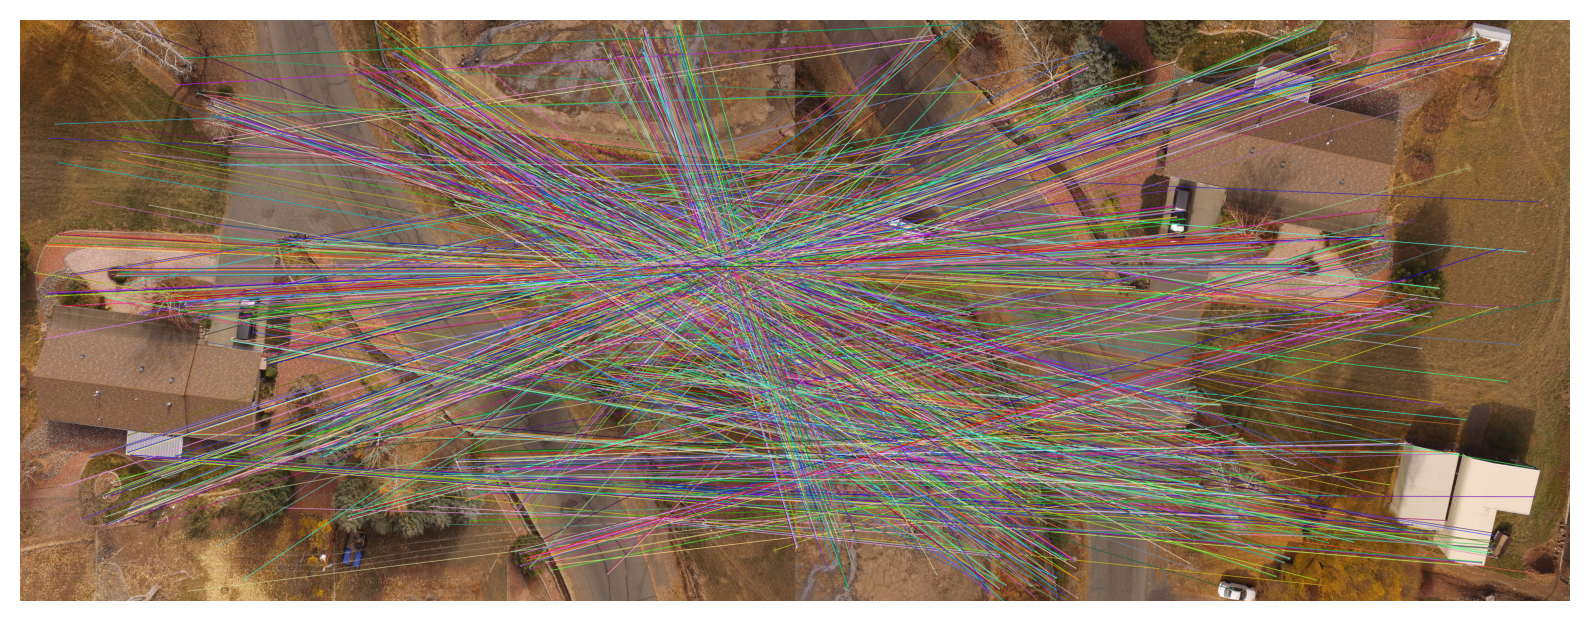

In [7]:
plt.figure(figsize=(10,5), dpi=200)
draw_img_match(im_A_path, im_B_path, matches_A[:5000], matches_B[:5000])
plt.axis('off')

In [11]:
import torch

In [12]:
images = torch.concat([descriptor.read_image(im_A_path, H = 784, W = 784), descriptor.read_image(im_B_path, H = 784, W = 784)])

In [13]:
class DeDoDeEnd2End(torch.nn.Module):
    def __init__(
        self,
        detector: dedode_detector_L,
        descriptor: dedode_descriptor_G,
        matcher: DualSoftMaxMatcher,
    ):
        super().__init__()
        self.detector = detector
        self.descriptor = descriptor
        self.matcher = matcher

    def forward(
        self,
        _images: torch.Tensor,  # (2B, C, H, W)
    ):
        images = {"im_A":_images[0:,:,:,:], "im_B":_images[1:,:,:,:]}
        keypoints = self.detector(images)
        descriptions = self.descriptor(images, keypoints)

        matches_A, matches_B, batch_ids, idxs
        matches_A, matches_B, batch_ids, idxs = self.matcher(
            keypoints[0::2], descriptions[0::2], keypoints[1::2], descriptions[1::2]
        )

        return (
            matches_A,  # (N, 2)
            matches_B,  # (N, 2)
            batch_ids,  # (N,)
        )

In [14]:
dedode_model = DeDoDeEnd2End(detector, descriptor, matcher)
dynamic_axes = {
    "images": {},
    "matches_A": {0: "num_matches"},
    "matches_B": {0: "num_matches"},
    "batch_ids": {0: "num_matches"},
}
dynamic_axes["images"].update({0: "batch_size"})


In [15]:
print(dynamic_axes)

{'images': {0: 'batch_size'}, 'matches_A': {0: 'num_matches'}, 'matches_B': {0: 'num_matches'}, 'batch_ids': {0: 'num_matches'}}


In [16]:
torch.onnx.export(dedode_model, 
                 images, 
                 filename="dedode_end2end.onnx",
                 method_name="forward",
                 verbose=True,
                 input_names=["images"], 
                 output_names=["matches_A", "matches_B", "batch_ids"],
                 opset_version=16,
                 dynamic_axes=dynamic_axes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 5.61 GiB of which 48.88 MiB is free. Including non-PyTorch memory, this process has 4.97 GiB memory in use. Of the allocated memory 4.67 GiB is allocated by PyTorch, and 198.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)